In [1]:
%reset -f
%reload_ext autoreload
%autoreload 2
%matplotlib inline
%config Completer.use_jedi = False

In [2]:
import sys
sys.path.insert(0,"..")
from tqdm import tqdm
# from tqdm.notebook import tqdm as tqdm
import numpy as np
import pandas as pd
import torch
torch.backends.cudnn.benchmark = True
torch.manual_seed(42)
import torch.nn as nn
import torch.optim as optim
import torchaudio
from torch.utils.data import Dataset, ConcatDataset
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets, transforms
torchaudio.set_audio_backend('soundfile')
import os
import random
from pathlib import Path
from IPython.display import Audio

import matplotlib.pyplot as plt
import psutil
import requests
from sklearn.model_selection import train_test_split
from utils import *
from datasets import *
from models import *
from transforms import *
from sklearn.metrics import confusion_matrix, balanced_accuracy_score
import  seaborn as sns

Available workers: 16


In [16]:
num_epochs = 35
batch_size = 64
batch_size_val = batch_size 
validation_split = .3
shuffle_dataset = True
num_workers = 4
random_seed= 42
setting = 'psdl2'
modeltype = 'psdl2'
normalize = ""#"sample"

train_df = pd.read_parquet('../data_created/suzmel_train.parquet')
test_df = pd.read_parquet('../data_created/suzmel_test.parquet')

transforms_list_train = [Bandpass(), RandomRoll(), TransformWingbeat(setting='psdl2')] # ,RandomFlip(), RandomNoise(), RandomRoll()]
transforms_list_test = [Bandpass(), TransformWingbeat(setting='psdl2')]


In [17]:
X, y = train_df.iloc[:, 0], train_df.iloc[:, 1]
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.13, shuffle=True, random_state=42, stratify=y)
X_test, y_test = test_df.iloc[:,0], test_df.iloc[:,1]

train_dataset = DataFrameset(pd.concat([X_train, y_train], axis=1), transform=transforms.Compose(transforms_list_train))
valid_dataset = DataFrameset(pd.concat([X_valid, y_valid], axis=1), transform=transforms.Compose(transforms_list_test))
test_dataset = DataFrameset(pd.concat([X_test, y_test], axis=1), transform=transforms.Compose(transforms_list_test))

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size_val, shuffle=True, num_workers=4, pin_memory=True, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size_val, shuffle=False, num_workers=4, pin_memory=True, worker_init_fn=worker_init_fn)

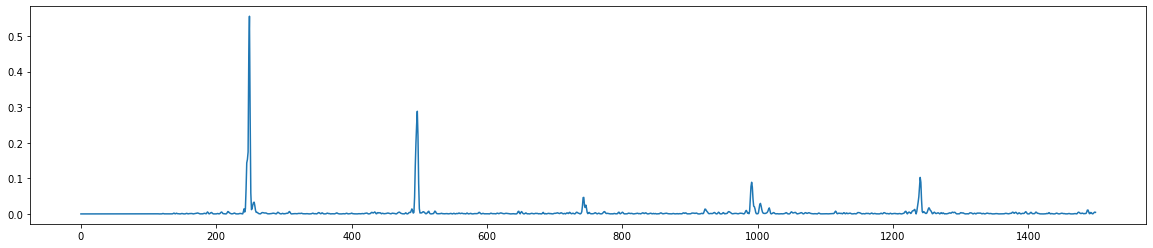

In [18]:
plt.figure(figsize=(20,4))
plt.plot(train_dataset[1][0].T);

In [19]:
outs = 2
if modeltype == 'psdl2':
    model = Conv1dNetRAW(outputs=outs)
elif modeltype == 'inception':
    model = nn.Sequential(
                    InceptionBlock(
                        in_channels=1, 
                        n_filters=32, 
                        kernel_sizes=[5, 11, 23],
                        bottleneck_channels=32,
                        use_residual=True,
                        activation=nn.ReLU()
                    ),
                    InceptionBlock(
                        in_channels=32*4, 
                        n_filters=32, 
                        kernel_sizes=[5, 11, 23],
                        bottleneck_channels=32,
                        use_residual=True,
                        activation=nn.ReLU()
                    ),
                    nn.AdaptiveAvgPool1d(output_size=1),
                    Flatten(out_features=32*4*1),
                    nn.Linear(in_features=4*32*1, out_features=1))

class_sample_count = np.unique(y_train, return_counts=True)[1]
weight = 1. / class_sample_count    

if outs == 1:
    criterion = torch.nn.BCEWithLogitsLoss(weight=torch.Tensor(weight))
elif outs == 2:
    criterion = nn.CrossEntropyLoss(weight=torch.Tensor(weight).cuda())

optimizer = optim.Adam(model.parameters(), lr=0.001, eps=1e-3, amsgrad=True)
scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.0001, max_lr=0.01, cycle_momentum=False, mode="triangular")
# early_stopping = EarlyStopping(patience=10, verbose=1)

## Training

In [20]:
# Choosing whether to train on a gpu
train_on_gpu = torch.cuda.is_available()
print(f'Train on gpu: {train_on_gpu}')# Number of gpus
model = model.to('cuda', dtype=torch.float)

results = {"loss":[], "val_loss":[], "train_accuracy":[], "valid_accuracy":[]}
best_valacc = 0
# Model training
for epoch in range(num_epochs):
    # Going through the training set
    correct_train = 0
    model.train()
    for x_batch,y_batch,_,_ in tqdm(train_dataloader, desc='Training..\t'):        
        y_batch = torch.as_tensor(y_batch).type(torch.LongTensor)
        x_batch,y_batch = x_batch.cuda(), y_batch.cuda()
        for param in model.parameters():
            param.grad = None
        pred = model(x_batch)
        if outs == 1:
            y_batch = y_batch.type(torch.FloatTensor).cuda()
            correct_train += ((pred>0.5).int().squeeze() == y_batch.squeeze()).float().sum().item()
            loss = criterion(pred, y_batch.unsqueeze(1))
        elif outs == 2:
            y_batch = y_batch.type(torch.LongTensor).cuda()
            correct_train += (pred.argmax(axis=1) == y_batch).float().sum().item()
            loss = criterion(pred, y_batch)
        loss.backward()
        optimizer.step()
    train_accuracy = correct_train / len(train_dataset) * 100.
    
    # Going through the validation set
    correct_valid = 0
    model.eval()
    for x_batch,y_batch,_,_ in tqdm(valid_dataloader, desc='Validating..\t'):
        y_batch = torch.as_tensor(y_batch)
        x_batch,y_batch = x_batch.cuda(), y_batch.cuda()
        pred = model(x_batch)
        if outs == 1:
            y_batch = y_batch.type(torch.FloatTensor).cuda()
            correct_valid += ((pred>0.5).int().squeeze().cuda() == y_batch.squeeze()).float().sum().item()
            val_loss = criterion(pred, y_batch.unsqueeze(1))
        elif outs == 2:
            y_batch = y_batch.type(torch.LongTensor).cuda()
            correct_valid += (pred.argmax(axis=1) == y_batch).float().sum().item()
            val_loss = criterion(pred, y_batch)
    valid_accuracy = correct_valid / len(valid_dataset) * 100.

    scheduler.step()
#     early_stopping(val_loss, model)
#     if early_stopping.early_stop:
#         print("Early stopping")
#         break

        # Printing results
    print(f"Epoch {epoch}: train_acc: {train_accuracy:.1f}% loss: {loss:.7f},  val_loss: {val_loss:.7f} val_acc: {valid_accuracy:.1f}%")
        
    is_best = valid_accuracy > best_valacc
    if is_best:
        print(f"Validation accuracy improved from {best_valacc:.2f} to {valid_accuracy:.2f}. Saving model..")
    best_valacc = max(valid_accuracy, best_valacc)
    save_checkpoint({
        'epoch': epoch,
        'state_dict': model.state_dict(),
        'best_valacc': best_valacc,
        'loss': results['loss'].append(loss),
        'val_loss': results['val_loss'].append(val_loss),
        'train_accuracy': results['train_accuracy'].append(train_accuracy),
        'valid_accuracy': results['valid_accuracy'].append(valid_accuracy),
        'optimizer' : optimizer.state_dict(),
    }, is_best)


Training..	:   0%|          | 0/377 [00:00<?, ?it/s]

Train on gpu: True


Validating..	: 100%|██████████| 57/57 [00:01<00:00, 41.32it/s]


Epoch 0: train_acc: 78.5% loss: 0.5287830,  val_loss: 0.3432509 val_acc: 82.6%
Validation accuracy improved from 0.00 to 82.65. Saving model..


Validating..	: 100%|██████████| 57/57 [00:01<00:00, 41.76it/s]


Epoch 1: train_acc: 84.3% loss: 0.2484405,  val_loss: 0.2566650 val_acc: 84.7%
Validation accuracy improved from 82.65 to 84.70. Saving model..


Validating..	: 100%|██████████| 57/57 [00:01<00:00, 43.52it/s]


Epoch 2: train_acc: 85.5% loss: 0.3552179,  val_loss: 0.1761956 val_acc: 86.1%
Validation accuracy improved from 84.70 to 86.06. Saving model..


Validating..	: 100%|██████████| 57/57 [00:01<00:00, 46.77it/s]


Epoch 3: train_acc: 86.4% loss: 0.3571435,  val_loss: 0.2101561 val_acc: 85.5%


Validating..	: 100%|██████████| 57/57 [00:01<00:00, 45.52it/s]


Epoch 4: train_acc: 86.7% loss: 0.3781452,  val_loss: 0.4885089 val_acc: 85.8%


Validating..	: 100%|██████████| 57/57 [00:01<00:00, 45.53it/s]


Epoch 5: train_acc: 87.3% loss: 0.6314482,  val_loss: 0.6068833 val_acc: 86.1%


Validating..	: 100%|██████████| 57/57 [00:01<00:00, 44.77it/s]


Epoch 6: train_acc: 87.9% loss: 0.3449415,  val_loss: 0.2297463 val_acc: 86.0%


Validating..	: 100%|██████████| 57/57 [00:01<00:00, 47.33it/s]


Epoch 7: train_acc: 88.3% loss: 0.3070416,  val_loss: 0.4264777 val_acc: 86.3%
Validation accuracy improved from 86.06 to 86.31. Saving model..


Validating..	: 100%|██████████| 57/57 [00:01<00:00, 43.72it/s]


Epoch 8: train_acc: 88.8% loss: 0.3333517,  val_loss: 0.2140384 val_acc: 86.2%


Validating..	: 100%|██████████| 57/57 [00:01<00:00, 46.26it/s]


Epoch 9: train_acc: 88.6% loss: 0.1847502,  val_loss: 0.3461683 val_acc: 86.3%


Validating..	: 100%|██████████| 57/57 [00:01<00:00, 44.18it/s]


Epoch 10: train_acc: 89.2% loss: 0.3577133,  val_loss: 0.2214038 val_acc: 86.7%
Validation accuracy improved from 86.31 to 86.67. Saving model..


Validating..	: 100%|██████████| 57/57 [00:01<00:00, 45.60it/s]


Epoch 11: train_acc: 89.5% loss: 0.2145963,  val_loss: 0.4802000 val_acc: 86.9%
Validation accuracy improved from 86.67 to 86.92. Saving model..


Validating..	: 100%|██████████| 57/57 [00:01<00:00, 47.30it/s]


Epoch 12: train_acc: 90.0% loss: 0.1839024,  val_loss: 0.4607157 val_acc: 87.0%
Validation accuracy improved from 86.92 to 87.03. Saving model..


Validating..	: 100%|██████████| 57/57 [00:01<00:00, 46.92it/s]


Epoch 13: train_acc: 90.4% loss: 0.1778469,  val_loss: 0.3901254 val_acc: 84.2%


Validating..	: 100%|██████████| 57/57 [00:01<00:00, 45.46it/s]


Epoch 14: train_acc: 90.5% loss: 0.2380119,  val_loss: 0.3261220 val_acc: 86.1%


Validating..	: 100%|██████████| 57/57 [00:01<00:00, 46.08it/s]


Epoch 15: train_acc: 90.8% loss: 0.2680206,  val_loss: 0.0915468 val_acc: 86.4%


Validating..	: 100%|██████████| 57/57 [00:01<00:00, 46.10it/s]


Epoch 16: train_acc: 91.4% loss: 0.3341503,  val_loss: 0.0759354 val_acc: 86.5%


Validating..	: 100%|██████████| 57/57 [00:01<00:00, 45.42it/s]


Epoch 17: train_acc: 91.5% loss: 0.1535077,  val_loss: 0.0780624 val_acc: 86.6%


Validating..	: 100%|██████████| 57/57 [00:01<00:00, 45.01it/s]


Epoch 18: train_acc: 91.7% loss: 0.2015790,  val_loss: 0.5918422 val_acc: 86.5%


Validating..	: 100%|██████████| 57/57 [00:01<00:00, 45.99it/s]


Epoch 19: train_acc: 92.0% loss: 0.2479359,  val_loss: 0.6086501 val_acc: 86.4%


Validating..	: 100%|██████████| 57/57 [00:01<00:00, 47.67it/s]


Epoch 20: train_acc: 92.3% loss: 0.1571138,  val_loss: 0.4111467 val_acc: 83.7%


Validating..	: 100%|██████████| 57/57 [00:01<00:00, 42.53it/s]


Epoch 21: train_acc: 92.4% loss: 0.2558676,  val_loss: 0.4460386 val_acc: 84.3%


Validating..	: 100%|██████████| 57/57 [00:01<00:00, 46.49it/s]


Epoch 22: train_acc: 92.7% loss: 0.1414988,  val_loss: 1.0435994 val_acc: 85.8%


Validating..	: 100%|██████████| 57/57 [00:01<00:00, 47.59it/s]


Epoch 23: train_acc: 92.9% loss: 0.1349082,  val_loss: 0.4031861 val_acc: 82.7%


Validating..	: 100%|██████████| 57/57 [00:01<00:00, 43.63it/s]


Epoch 24: train_acc: 93.0% loss: 0.2837196,  val_loss: 0.9365238 val_acc: 85.6%


Validating..	: 100%|██████████| 57/57 [00:01<00:00, 42.94it/s]


Epoch 25: train_acc: 93.2% loss: 0.2985165,  val_loss: 0.2198350 val_acc: 85.0%


Validating..	: 100%|██████████| 57/57 [00:01<00:00, 45.19it/s]


Epoch 26: train_acc: 93.4% loss: 0.1668513,  val_loss: 0.8854676 val_acc: 73.6%


Validating..	: 100%|██████████| 57/57 [00:01<00:00, 43.95it/s]


Epoch 27: train_acc: 93.7% loss: 0.0894994,  val_loss: 0.6176797 val_acc: 82.8%


Validating..	: 100%|██████████| 57/57 [00:01<00:00, 46.19it/s]


Epoch 28: train_acc: 93.7% loss: 0.2026327,  val_loss: 0.7097672 val_acc: 85.1%


Validating..	: 100%|██████████| 57/57 [00:01<00:00, 46.64it/s]


Epoch 29: train_acc: 93.7% loss: 0.1399511,  val_loss: 0.1092786 val_acc: 82.2%


Validating..	: 100%|██████████| 57/57 [00:01<00:00, 46.82it/s]


Epoch 30: train_acc: 94.0% loss: 0.0773831,  val_loss: 0.4549240 val_acc: 86.5%


Validating..	: 100%|██████████| 57/57 [00:01<00:00, 46.93it/s]


Epoch 31: train_acc: 94.1% loss: 0.1577874,  val_loss: 0.8116723 val_acc: 84.4%


Validating..	: 100%|██████████| 57/57 [00:01<00:00, 43.47it/s]


Epoch 32: train_acc: 94.2% loss: 0.0715978,  val_loss: 0.1720727 val_acc: 83.8%


Validating..	: 100%|██████████| 57/57 [00:01<00:00, 47.61it/s]


Epoch 33: train_acc: 94.5% loss: 0.1578620,  val_loss: 3.6539972 val_acc: 73.1%


Validating..	: 100%|██████████| 57/57 [00:01<00:00, 45.41it/s]


Epoch 34: train_acc: 94.4% loss: 0.1635888,  val_loss: 0.4727626 val_acc: 85.9%


# MORE LAYERS?

## Testing on test set

In [21]:
model, optimizer = load_checkpoint(f'{BASE_DATACREATEDDIR}/model_best.pth.tar', model, optimizer)

In [22]:
_ = test_model(model,test_dataloader, test_dataset)

Testing..	: 100%|██████████| 368/368 [00:06<00:00, 52.61it/s]

Accuracy: 85.69
Balanced accuracy: 85.08
Confusion matrix: 
[[0.80610642 0.19389358]
 [0.10441165 0.89558835]]


## Testing on extra mebios data

In [23]:
extra_df = pd.read_csv('../data_created/suzmel_extra.csv')
X_extra, y_extra = extra_df.iloc[:,0], extra_df.iloc[:,1]

extra_dataset = DataFrameset(pd.concat([X_extra, y_extra], axis=1), transform=transforms.Compose(transforms_list_test))
extra_dataloader = DataLoader(extra_dataset, batch_size=batch_size_val, shuffle=False, num_workers=4, pin_memory=True, worker_init_fn=worker_init_fn)

In [24]:
_ = test_model(model,extra_dataloader, extra_dataset)

Testing..	: 100%|██████████| 317/317 [00:06<00:00, 49.05it/s]


Accuracy: 84.02
Balanced accuracy: 85.98
Confusion matrix: 
[[0.88141026 0.11858974]
 [0.16183325 0.83816675]]


In [25]:
def softmax_out(x):
    return np.argmax(F.softmax(x, dim=1), axis=1).tolist()[0]

In [26]:
df_out = get_all_preds(model, test_dataloader, dataframe=True, binary=False)

100%|██████████| 368/368 [00:07<00:00, 48.72it/s]


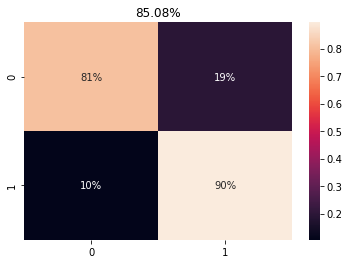

In [27]:
cm = confusion_matrix(y_true = df_out.y, y_pred=df_out.softmax, normalize='true')
sns.heatmap(cm, annot=True, fmt='.0%')
plt.title(f"{balanced_accuracy_score(y_true = df_out.y, y_pred=df_out.softmax):.2%}");